In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


### Load Data

In [26]:
df = pd.read_csv('../input/heart.csv')
df.shape

(303, 14)

In [27]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### See if the target class is unbalanced

In [28]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

### Create histogram function to see distribution of various numerical variables

In [29]:
def histogram(col_name, title, xlabel):
    fig, ax = plt.subplots()
    df[col_name].hist(color='#A9C5D3', edgecolor='black', grid=False)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

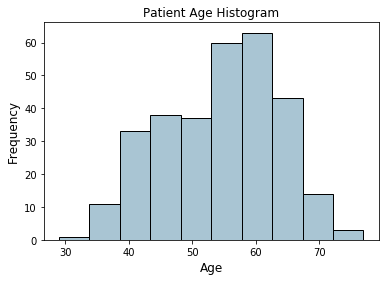

In [30]:
histogram('age', 'Patient Age Histogram', 'Age')

### Binning of Continuous Variables
As we can see from above histogram, the age is skewed towards right. 
* We can do binning of such variables. 
* Binning, also known as quantization is used for transforming continuous numeric features into discrete ones (categories). These discrete values or numbers can be thought of as categories or bins into which the raw, continuous numeric values are binned or grouped into. 
* We can either do a fixed-width binning which means we decide the bins ourselves for a variable such as age like 0-20, 21-50, 51-70, 70+, or we do adaptive binning.
* The drawback in using fixed-width binning is that due to us manually deciding the bin ranges, we can end up with irregular bins which are not uniform based on the number of data points or values which fall in each bin. Some of the bins might be densely populated and some of them might be sparsely populated or even empty! Adaptive binning is a safer strategy in these scenarios where we let the data speak for itself! That’s right, we use the data distribution itself to decide our bin ranges.
* Quantile based binning is a good strategy to use for adaptive binning. 
* Quantiles are specific values or cut-points which help in partitioning the continuous valued distribution of a specific numeric field into discrete contiguous bins or intervals.

In [31]:
def cut_quantile(quant_col_name, col_to_cut):
    quantile_list = [0, 0.25, 0.5, 0.75, 1.0]
    quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
    df[quant_col_name] = pd.qcut(df[col_to_cut], q=quantile_list, labels=quantile_labels)

In [32]:
cut_quantile('age_quantile_label', 'age')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_quantile_label
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,75-100Q
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,0-25Q
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0-25Q
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,50-75Q
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,50-75Q


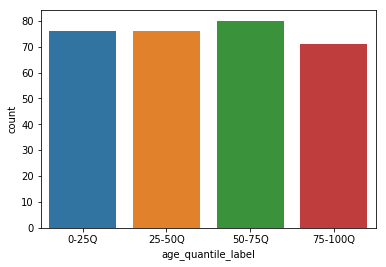

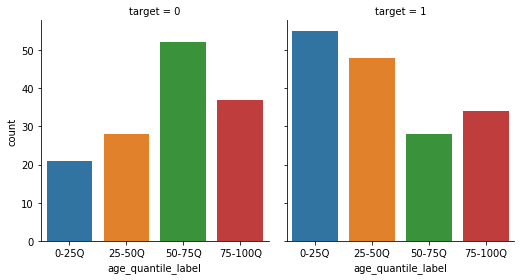

In [33]:
sns.countplot('age_quantile_label', data=df);
sns.catplot(x="age_quantile_label", col="target", data=df, kind="count", height=4, aspect=.9);

Similar exercise is done for variables like **'trestbps'** and **'patient cholestrol'**

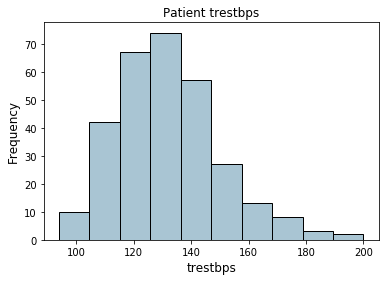

In [34]:
histogram('trestbps', 'Patient trestbps', 'trestbps')

In [35]:
cut_quantile('trestbps_quantile_label', 'trestbps')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_quantile_label,trestbps_quantile_label
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,75-100Q,75-100Q
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,0-25Q,25-50Q
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0-25Q,25-50Q
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,50-75Q,0-25Q
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,50-75Q,0-25Q


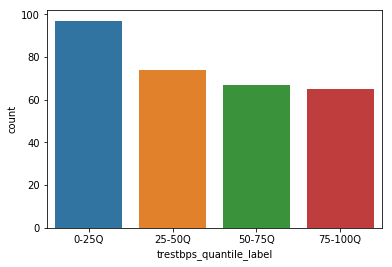

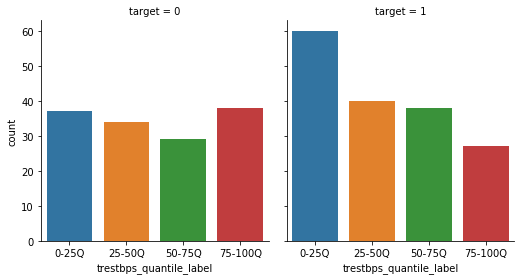

In [36]:
sns.countplot('trestbps_quantile_label', data=df);
sns.catplot(x="trestbps_quantile_label", col="target", data=df, kind="count", height=4, aspect=.9);

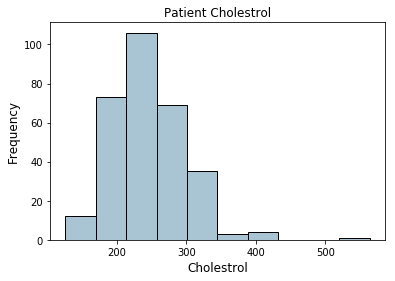

In [37]:
histogram('chol', 'Patient Cholestrol', 'Cholestrol')

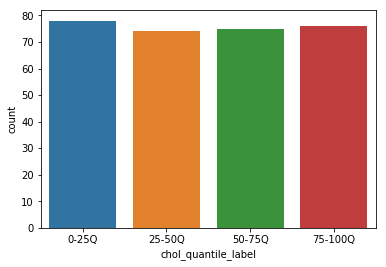

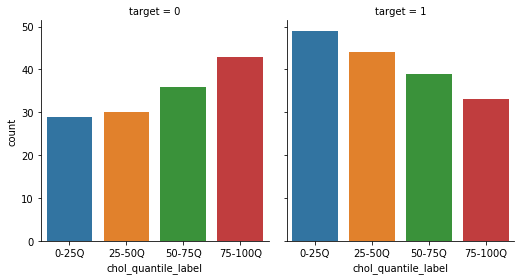

In [38]:
cut_quantile('chol_quantile_label', 'chol')
sns.countplot('chol_quantile_label', data=df);
sns.catplot(x="chol_quantile_label", col="target", data=df, kind="count", height=4, aspect=.9);

### Ready Train and Test Data
Remove the variables age, trestbps, chol and target and use get_dummies to transform categorical features to numerical binary features

In [39]:
refined_df = df
target = refined_df['target']

refined_df = refined_df.drop(['age','chol', 'trestbps', 'target'], axis=1)
refined_df = pd.get_dummies(refined_df)
refined_df.head(5)

,sex,cp,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,age_quantile_label_0-25Q,age_quantile_label_25-50Q,age_quantile_label_50-75Q,age_quantile_label_75-100Q,trestbps_quantile_label_0-25Q,trestbps_quantile_label_25-50Q,trestbps_quantile_label_50-75Q,trestbps_quantile_label_75-100Q,chol_quantile_label_0-25Q,chol_quantile_label_25-50Q,chol_quantile_label_50-75Q,chol_quantile_label_75-100Q
0,1,3,1,0,150,0,2.3,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
1,1,2,0,1,187,0,3.5,0,0,2,1,0,0,0,0,1,0,0,0,0,1,0
2,0,1,0,0,172,0,1.4,2,0,2,1,0,0,0,0,1,0,0,1,0,0,0
3,1,1,0,1,178,0,0.8,2,0,2,0,0,1,0,1,0,0,0,0,1,0,0
4,0,0,0,1,163,1,0.6,2,0,2,0,0,1,0,1,0,0,0,0,0,0,1


In [40]:
X_train, X_test, y_train, y_test = train_test_split(refined_df, target, test_size=0.20, random_state=42)

### ROC-AUC Metric
**Create a function to draw ROC-AUC plot for the model**

We will use ROC-AUC plot here because there is not much class imbalance because -
* There is almost negligible class imbalance (165 vs 138)
* Precision-Recall curves are generally suited when there is moderate to high class imbalance

> ROC-AUC plots draw a curve between True Positive Rate and False Positive Rate <br>
**True Positive Rate** = TP/(TP+FP)<br>
**False Positive Rate** = FP/(FP+TN)

We will use roc_curve from sklearn to derive roc-auc curve. This function in sklearn returns a list of False Positive rates and True Positive Rates against a list of threshold values.

In [41]:
def plot_roc_(false_positive_rate,true_positive_rate,roc_auc):
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

**Create a function to print accuracy, roc_auc score, F1 score and recall of the classification model**

In [42]:
models_data = dict()
def analyse_model(model, name):
    y_preds = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba[:,1])
    roc_auc = round(auc(false_positive_rate, true_positive_rate), 3)
    accuracy = round(accuracy_score(y_test, y_preds), 3)
    f1 = round(f1_score(y_test, y_preds), 3)
    recall = round(recall_score(y_test, y_preds), 3)
    plot_roc_(false_positive_rate, true_positive_rate, roc_auc)
    
    print("Accuracy {}".format(accuracy))
    print("F1 Score {}".format(f1))
    print("AUC Score {}".format(roc_auc))
    print("Recall {}".format(recall))
    models_data[name] = [roc_auc, accuracy, f1, recall] 

### Logistic Regression Model

* Logistic Regression assigns probabilities to the regression score which is calculated as product of coefficients of the variables and the variable value itself
$$Score = \hat(w) h(x)$$
$$ P(y=+1 | w) = \frac{1}{1 + \mathrm{e}^{-\hat(w) h(x)}}$$

**This means for a score with a value of $\infty$ the probability assigned is 1 and for a score with value of -$\infty$ the probability assigned is 0**

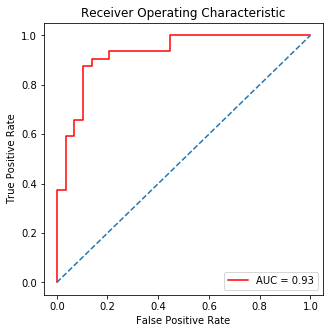

Accuracy 0.885
F1 Score 0.892
AUC Score 0.927
Recall 0.906


In [43]:
logs_regr_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000).fit(X_train, y_train)
analyse_model(logs_regr_model, "Logistic Regression")

### Logistic Regression Model with Grid Search

{'C': 0.1}


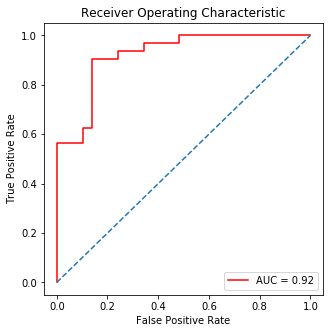

Accuracy 0.885
F1 Score 0.892
AUC Score 0.921
Recall 0.906


In [44]:
parameters = {'C': [0.01, 0.05, 0.1, 0.5, 1]}
logs_grid_model = GridSearchCV(logs_regr_model, parameters, scoring='roc_auc')
logs_grid_model.fit(X_train, y_train)
print(logs_grid_model.best_params_)
analyse_model(logs_grid_model, "Logistic Regression GS")

### Decision Tree Model

A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps you in decision making. It's visualization like a flowchart diagram which easily mimics the human level thinking. That is why decision trees are easy to understand and interpret.

![](https://www.xoriant.com/blog/wp-content/uploads/2017/08/Decision-Trees-modified-1.png)

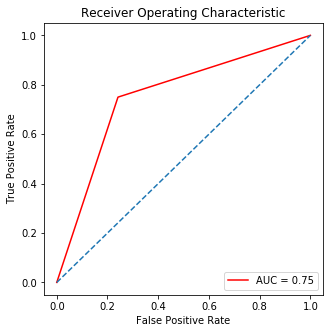

Accuracy 0.754
F1 Score 0.762
AUC Score 0.754
Recall 0.75


In [45]:
dec_tree_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
analyse_model(dec_tree_model, "Decision Tree")

### Decision Tree Model with Grid Search

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5}


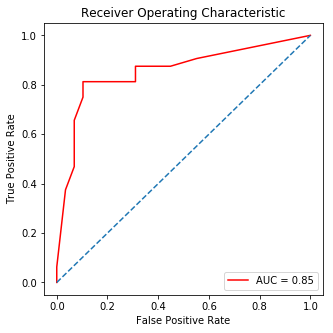

Accuracy 0.852
F1 Score 0.852
AUC Score 0.855
Recall 0.812


In [46]:
parameters = {'max_depth': [2, 3, 4, 5, 6, 7], 'criterion': ('gini', 'entropy'), 
              'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3, 4]}
dec_grid_model = GridSearchCV(dec_tree_model, parameters, scoring='roc_auc')
dec_grid_model.fit(X_train, y_train)

print(dec_grid_model.best_params_)
analyse_model(dec_grid_model, "Decision Tree GS")

### Random Forest Model

Random Forest Classifier works in following way -
* It uses number of decision trees called estimators
* It divides the training data into subsets. These subsets are created using pick-one-replace-one algorithm like below <br>
> [X1, X2, X3]<br>
> [X1, X4, X3]<br>
> [X4, X2, X1]<br>
* This votes from different trees or estimators are aggregated to produce the final output.
* Random Forest Classifier has the tendency to cancel overfitting from individual trees

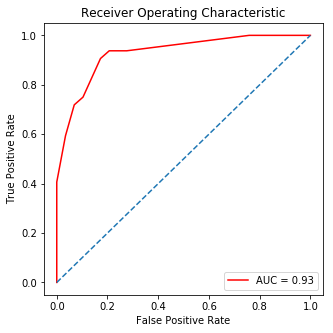

Accuracy 0.82
F1 Score 0.814
AUC Score 0.928
Recall 0.75


In [47]:
rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
analyse_model(rf_model, "Random Forest")

### Random Forest Model with Grid Search

{'max_depth': 4, 'n_estimators': 100}


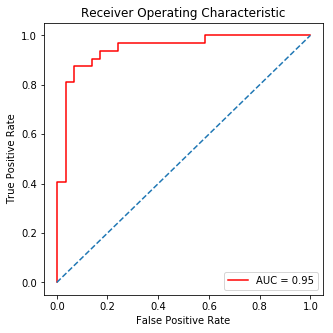

Accuracy 0.869
F1 Score 0.879
AUC Score 0.946
Recall 0.906


In [48]:
parameters = {'n_estimators': [10, 50, 100], 'max_depth': [2, 3, 4, 5, 6, 7]}
rf_grid_model = GridSearchCV(rf_model, parameters, scoring='roc_auc').fit(X_train, y_train)
print(rf_grid_model.best_params_)
analyse_model(rf_grid_model, "Random Forest GS")

### Gradient Boosting Model

* Here, we choose the subsets of data sequentially not parallely.
* This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. 
* Because new predictors are learning from mistakes committed by previous predictors, it takes less time/iterations to reach close to actual predictions. But we have to choose the stopping criteria carefully or it could lead to overfitting on training data.
* We first model data with simple models and analyze data for errors. 
* These errors signify data points that are difficult to fit by a simple model. 
* Then for later models, we particularly focus on those hard to fit data to get them right. 
* In the end, we combine all the predictors by giving some weights to each predictor.

**The idea is to use the weak learning method several times to get a succession of hypotheses, each one refocused on the examples that the previous ones found difficult and misclassified.**

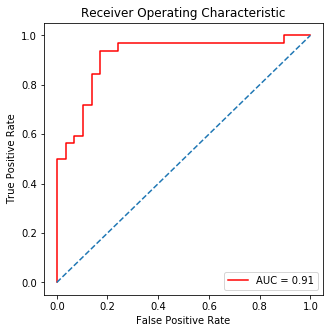

Accuracy 0.852
F1 Score 0.857
AUC Score 0.914
Recall 0.844


In [49]:
gbm_model = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
analyse_model(gbm_model, "Gradient Boost")

### Gradient Boosting Model with Grid Search

{'max_depth': 3, 'n_estimators': 10}


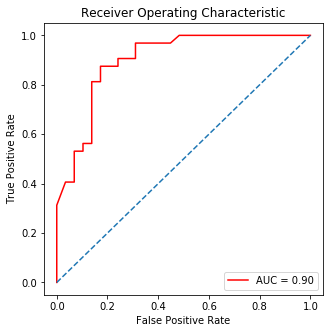

Accuracy 0.852
F1 Score 0.862
AUC Score 0.9
Recall 0.875


In [50]:
parameters = {'n_estimators': [10, 100], 'max_depth': [2, 3, 4, 5, 6, 7]}
gbm_grid_model = GridSearchCV(gbm_model, parameters, scoring='roc_auc').fit(X_train, y_train)
print(gbm_grid_model.best_params_)
analyse_model(gbm_grid_model, "Gradient Boost GS")

### XGBoost Model

* XGBoost is advanced form of gradient boosting which penalizes more complex models through both LASSO (L1) and Ridge (L2) regularization to prevent overfitting.
* The algorithm comes with built-in cross-validation method at each iteration, taking away the need to explicitly program this search and to specify the exact number of boosting iterations required in a single run.

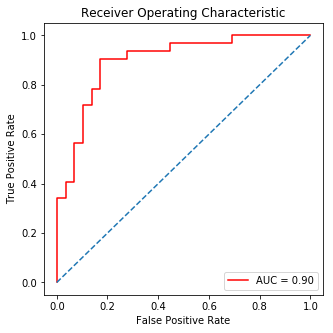

Accuracy 0.82
F1 Score 0.825
AUC Score 0.897
Recall 0.812


In [51]:
xgb_model = xgb.XGBClassifier(random_state=0).fit(X_train, y_train)
analyse_model(xgb_model, "XGBoost")

### XGBoost Model with Grid Search

{'max_depth': 3, 'n_estimators': 100}
0.8764021722699408


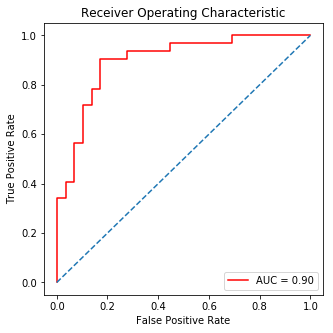

Accuracy 0.82
F1 Score 0.825
AUC Score 0.897
Recall 0.812


In [52]:
parameters = {'n_estimators': [10, 100], 'max_depth': [2, 3, 4, 5, 6, 7]}
xgb_grid_model = GridSearchCV(xgb_model, parameters, scoring='roc_auc').fit(X_train, y_train)
print(xgb_grid_model.best_params_)
print(xgb_grid_model.best_score_)
analyse_model(xgb_grid_model, "XGBoost GS")

### AUC Score Comparison of different classifiers

In [53]:
score_df = pd.DataFrame.from_dict(models_data, orient='index', columns=['AUC Score', 'Accuracy', 'F1 Score', 'Recall'])
score_df.sort_values(by=['AUC Score'], ascending=False)

,AUC Score,Accuracy,F1 Score,Recall
Random Forest GS,0.946,0.869,0.879,0.906
Random Forest,0.928,0.820,0.814,0.750
Logistic Regression,0.927,0.885,0.892,0.906
Logistic Regression GS,0.921,0.885,0.892,0.906
Gradient Boost,0.914,0.852,0.857,0.844
Gradient Boost GS,0.900,0.852,0.862,0.875
XGBoost,0.897,0.820,0.825,0.812
XGBoost GS,0.897,0.820,0.825,0.812
Decision Tree GS,0.855,0.852,0.852,0.812
Decision Tree,0.754,0.754,0.762,0.750
